### look back values for btc_close price
look_back_values = [1, 2, 5, 10, 20]

In [120]:
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
from skopt.space import Real, Categorical, Integer
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator

device = torch.device("cpu")

In [121]:
from skorch.callbacks import Callback
from tqdm import tqdm

class TqdmProgressBar(Callback):
    def on_train_begin(self, net, **kwargs):
        self.epochs = net.max_epochs
        self.pbar = tqdm(total=self.epochs, desc="Training Progress", unit="epoch")

    def on_epoch_end(self, net, **kwargs):
        self.pbar.update(1)  # Increment the progress bar by one epoch

    def on_train_end(self, net, **kwargs):
        self.pbar.close()


In [122]:
train_residuals_df = pd.read_csv("../data/final/train_residuals_df.csv", parse_dates=["Date"], index_col="Date")
test_residuals_df = pd.read_csv("../data/final/test_residuals_df.csv", parse_dates=["Date"], index_col="Date")

train_residual = train_residuals_df["Residuals"]
test_residual = test_residuals_df["Residuals"]

In [123]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.values.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.values.reshape(-1, 1))

# save scaler
joblib.dump(scaler, "../models/residual_scaler.pkl")

['../models/residual_scaler.pkl']

In [124]:
train_residual_scaled = train_residual_scaled.astype(np.float32)
test_residual_scaled = test_residual_scaled.astype(np.float32)

In [125]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.position_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))

    def forward(self, x):
        return self.position_encoding[:, :x.size(1), :]

In [126]:
import torch
import torch.nn as nn

class Seq2SeqTemporalFusionTransformer(nn.Module):
    def __init__(self, look_back, num_heads, hidden_dim, feed_forward_dim, dropout_rate,
                 num_layers=1, activation="relu", input_feature_dim=1, n_steps_ahead=1):
        super(Seq2SeqTemporalFusionTransformer, self).__init__()
        self.look_back = look_back
        self.n_steps_ahead = n_steps_ahead
        self.hidden_dim = hidden_dim

        # Input projection
        self.input_projection = nn.Linear(input_feature_dim, hidden_dim)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(max_len=look_back + n_steps_ahead, hidden_dim=hidden_dim)

        # Define the activation function dynamically
        if activation == "relu":
            self.activation_fn = nn.ReLU()
        elif activation == "gelu":
            self.activation_fn = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.ModuleDict({
                "multi_head_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.ModuleDict({
                "self_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "cross_attention": nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True),
                "layer_norm1": nn.LayerNorm(hidden_dim),
                "feed_forward": nn.Sequential(
                    nn.Linear(hidden_dim, feed_forward_dim),
                    self.activation_fn,
                    nn.Dropout(dropout_rate),
                    nn.Linear(feed_forward_dim, hidden_dim)
                ),
                "layer_norm2": nn.LayerNorm(hidden_dim)
            })
            for _ in range(num_layers)
        ])

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_feature_dim)

    def forward(self, src, tgt):
        # Input projection
        src = self.input_projection(src)  # Shape: (batch_size, look_back, hidden_dim)
        tgt = self.input_projection(tgt)  # Shape: (batch_size, n_steps_ahead, hidden_dim)

        # Add positional encoding
        src = src + self.positional_encoding(src)
        tgt = tgt + self.positional_encoding(tgt)

        # Encoder
        for layer in self.encoder_layers:
            # Self-attention
            attn_output, _ = layer["multi_head_attention"](src, src, src)
            src = layer["layer_norm1"](src + attn_output)

            # Feed-forward network
            ff_output = layer["feed_forward"](src)
            src = layer["layer_norm2"](src + ff_output)

        # Decoder
        for layer in self.decoder_layers:
            # Self-attention
            self_attn_output, _ = layer["self_attention"](tgt, tgt, tgt)
            tgt = layer["layer_norm1"](tgt + self_attn_output)

            # Cross-attention (attends to encoder output)
            cross_attn_output, _ = layer["cross_attention"](tgt, src, src)
            tgt = layer["layer_norm1"](tgt + cross_attn_output)

            # Feed-forward network
            ff_output = layer["feed_forward"](tgt)
            tgt = layer["layer_norm2"](tgt + ff_output)

        # Output projection
        outputs = self.output_layer(tgt)  # Shape: (batch_size, n_steps_ahead, input_feature_dim)
        return outputs

### Hyperparameters Tuning using Bayes Optimization

In [127]:
class Seq2SeqTemporalFusionTransformerWrapper(nn.Module):
    def __init__(self, look_back, num_heads, head_dim, feed_forward_dim, dropout_rate, num_layers, activation, n_steps_ahead):
        super(Seq2SeqTemporalFusionTransformerWrapper, self).__init__()
        self.look_back = look_back
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        self.activation = activation
        self.n_steps_ahead = n_steps_ahead
        
        # Initialize the Seq2Seq TFT model
        self.model = Seq2SeqTemporalFusionTransformer(
            look_back=look_back,
            num_heads=num_heads,
            hidden_dim=num_heads * head_dim,
            feed_forward_dim=feed_forward_dim,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            activation=activation,
            input_feature_dim=1,  # Assuming univariate time series
            n_steps_ahead=n_steps_ahead
        )

    def forward(self, src, tgt=None):
        if src.dim() == 2:
            src = src.unsqueeze(-1)  # Add feature dimension if missing
        
        # If tgt is not provided (during inference), initialize it with zeros
        if tgt is None:
            tgt = torch.zeros(src.size(0), self.n_steps_ahead, 1).to(src.device)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Ensure tgt is 3D: (batch_size, n_steps_ahead, input_feature_dim)
        if tgt.dim() == 2:
            tgt = tgt.unsqueeze(-1)  # Add feature dimension if missing
        
        # Forward pass through the model
        outputs = self.model(src, tgt)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Reshape output to (batch_size, n_steps_ahead)
        outputs = outputs.squeeze(-1)  # Remove the last dimension if it's 1
        
        return outputs
    
    def state_dict(self, *args, **kwargs):
        """
        Override to save only the state_dict of the underlying model.
        """
        return {
            'model_state_dict': self.model.state_dict(),
            'hyperparameters': {
                'look_back': self.look_back,
                'num_heads': self.num_heads,
                'head_dim': self.head_dim,
                'feed_forward_dim': self.feed_forward_dim,
                'dropout_rate': self.dropout_rate,
                'num_layers': self.num_layers,
                'activation': self.activation,
                'n_steps_ahead': self.n_steps_ahead
            }
        }

    def load_state_dict(self, state_dict, strict=True):
        """
        Override to load the state_dict into the underlying model.
        """
        self.model.load_state_dict(state_dict['model_state_dict'], strict=strict)

    def predict(self, X):
        """
        Predict on given input data (e.g., X_test or future data).
        
        Parameters:
        - X (np.ndarray or torch.Tensor): Input data of shape (batch_size, look_back).
        
        Returns:
        - np.ndarray: Predicted values of shape (batch_size, n_steps_ahead).
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        if X.dim() == 2:
            X = X.unsqueeze(-1)  # Add feature dimension if missing

        # Set the model to evaluation mode
        self.eval()

        with torch.no_grad():
            predictions = self.forward(X)  # Forward pass for prediction

        return predictions.numpy()

In [128]:
# Define search space for BayesSearchCV
search_space = {
    "num_heads": Categorical([2, 4, 8]),  
    "head_dim": Categorical([8, 16, 32]),  
    "feed_forward_dim": Categorical([128, 256, 512, 1024]),  
    "dropout_rate": Real(0.1, 0.4),  
    "lr": Real(5e-5, 5e-3, prior="log-uniform"), 
    "batch_size": Categorical([16, 32, 64]), 
    "num_layers": Categorical([1, 2, 3, 4]),
    "activation": Categorical(["relu", "gelu"]),
}

In [129]:
def create_multi_step_dataset(data, look_back, n_steps_ahead=1):
    X, y = [], []
    for i in range(len(data) - look_back - n_steps_ahead + 1):
        X.append(data[i:i + look_back, 0])  # Input sequence
        y.append(data[i + look_back:i + look_back + n_steps_ahead, 0])  # Multi-step target
    return np.array(X), np.array(y)

# Prepare training and testing datasets
look_back = 7
n_steps_ahead = 3

# Create train and test datasets
X_train, y_train = create_multi_step_dataset(train_residual_scaled, look_back, n_steps_ahead)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = create_multi_step_dataset(test_residual_scaled, look_back, n_steps_ahead)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(722, 7, 1) (722, 3) (722, 7, 1) (722, 3)


In [130]:
from sklearn.base import BaseEstimator
import torch
import torch.nn as nn

class TFTEstimator(BaseEstimator):
    def __init__(self, look_back=7, num_heads=4, head_dim=16, feed_forward_dim=128,
                 dropout_rate=0.1, lr=0.001, batch_size=32, num_layers=2, activation="relu", n_steps_ahead=3):
        self.look_back = look_back
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.activation = activation
        self.n_steps_ahead = n_steps_ahead

        # Store model hyperparameters
        self.model_params = {
            "look_back": look_back,
            "num_heads": num_heads,
            "head_dim": head_dim,
            "feed_forward_dim": feed_forward_dim,
            "dropout_rate": dropout_rate,
            "num_layers": num_layers,
            "activation": activation,
            "n_steps_ahead": n_steps_ahead,
        }

        # # Store training hyperparameters
        # self.training_params = {
        #     "lr": lr,
        #     "batch_size": batch_size,
        # }
        
        # Initialize the Seq2Seq TFT model
        self.model = Seq2SeqTemporalFusionTransformerWrapper(**self.model_params)

    def fit(self, X, y):
        # Convert inputs to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (batch_size, look_back, 1)
        y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (batch_size, n_steps_ahead, 1)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Training loop
        for epoch in range(10):  # Example: 10 epochs
            optimizer.zero_grad()
            outputs = self.model(X_tensor, y_tensor)  # Forward pass with src and tgt
            loss = criterion(outputs, y_tensor)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
        return self

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (batch_size, look_back, 1)
            predictions = self.model(X_tensor)  # Forward pass with src only (tgt is initialized internally)
        return predictions.numpy()

In [131]:
# Wrap the model with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=TFTEstimator(
        look_back=look_back,
        n_steps_ahead=n_steps_ahead
    ),
    search_spaces=search_space,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the search
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1, Loss: 0.962406575679779
Epoch 1, Loss: 2.16645884513855
Epoch 2, Loss: 0.21383409202098846
Epoch 1, Loss: 0.2323056161403656
Epoch 3, Loss: 0.1499336063861847
Epoch 1, Loss: 0.07551693171262741
Epoch 2, Loss: 0.727787435054779
Epoch 4, Loss: 0.3229321241378784
Epoch 1, Loss: 0.038884177803993225
Epoch 5, Loss: 0.35998401045799255
Epoch 2, Loss: 0.06475327908992767
Epoch 3, Loss: 0.14011502265930176
Epoch 6, Loss: 0.2703181207180023
Epoch 7, Loss: 0.15225014090538025
Epoch 4, Loss: 0.19440127909183502
Epoch 2, Loss: 0.20757469534873962
Epoch 8, Loss: 0.06647145748138428
Epoch 3, Loss: 0.1725991815328598
Epoch 2, Loss: 0.32068172097206116
Epoch 9, Loss: 0.04690491780638695
Epoch 5, Loss: 0.4452691674232483
Epoch 10, Loss: 0.0785691887140274
[CV] END activation=relu, batch_size=64, dropout_rate=0.37986039965435026, feed_forward_dim=256, head_dim=32, lr=0.0003366722096076183, num_heads=4, num_layers=3; total time=   0.9s
E

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=TFTEstimator(), n_jobs=-1, random_state=42,
              scoring='neg_mean_absolute_error',
              search_spaces={'activation': Categorical(categories=('relu', 'gelu'), prior=None),
                             'batch_size': Categorical(categories=(16, 32, 64), prior=None),
                             'dropout_rate': Real(low=0.1, high=0.4, prio...transform='normalize'),
                             'feed_forward_dim': Categorical(categories=(128, 256, 512, 1024), prior=None),
                             'head_dim': Categorical(categories=(8, 16, 32), prior=None),
                             'lr': Real(low=5e-05, high=0.005, prior='log-uniform', transform='normalize'),
                             'num_heads': Categorical(categories=(2, 4, 8), prior=None),
                             'num_layers': Categorical(categories=(1, 2, 3, 4), prior=None)},
              verbose=2)

In [132]:
best_estimator = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_

In [133]:
joblib.dump(bayes_search.best_estimator_, "../models/lookback7/tft_best_estimator.pkl")

['../models/lookback7/tft_best_estimator.pkl']

In [134]:
# Load the trained estimator
best_estimator = joblib.load("../models/lookback7/tft_best_estimator.pkl")

# Access the trained PyTorch model
trained_model = best_estimator.model
trained_model.eval()  # Set to evaluation mode for predictions

Seq2SeqTemporalFusionTransformerWrapper(
  (model): Seq2SeqTemporalFusionTransformer(
    (input_projection): Linear(in_features=1, out_features=64, bias=True)
    (positional_encoding): PositionalEncoding()
    (activation_fn): ReLU()
    (encoder_layers): ModuleList(
      (0-1): 2 x ModuleDict(
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=64, bias=True)
        )
        (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (decoder_layers): ModuleList(
      (0-1): 2 x ModuleDict(
        (self_attention): MultiheadAttention(
          (out_proj

In [135]:
# Make predictions
y_pred = trained_model.predict(X_test)

# Inverse transform the predictions
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Evaluate the predictions
mse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# save metrics as dataframe and save to csv
metrics = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'MAPE': [mape]})
metrics.to_csv('../results/metrics/lookback7/tft_seq2seq_metrics.csv', index=False)

# Save the predictions as .npy file
np.save('../results/predictions/test/lookback7/tft_seq2seq_predictions.npy', y_pred_inverse)

Mean Squared Error (MSE): 0.8725356459617615
Mean Absolute Error (MAE): 0.8342059254646301
Mean Absolute Percentage Error (MAPE): 5.713079452514648


### Save the model weights and optimizer

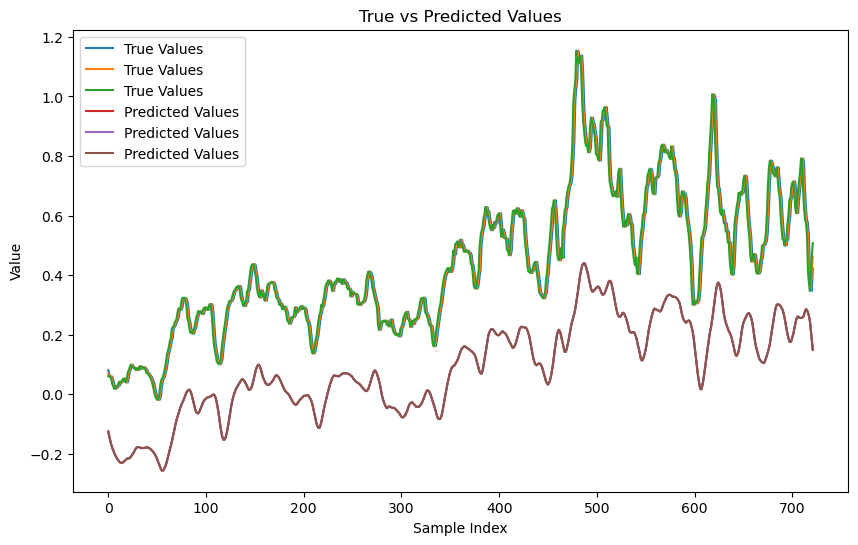

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.show()

In [140]:
future_days = 10

# Get the most recent data
recent_data = X_test[-1].reshape(1, -1, 1)  # Shape: (1, look_back, 1)
recent_data = torch.tensor(recent_data, dtype=torch.float32)

# Initialize a single list to store all predictions
predictions = []  # This will store predictions for all 3 cases

# Make predictions
for _ in range(future_days):
    with torch.no_grad():
        # Predict the next `n_steps_ahead` days
        prediction = trained_model(recent_data)  # Shape: (1, n_steps_ahead)
    
    # Append all predicted values to the predictions list
    predictions.append(prediction.squeeze().tolist())  # Shape: (n_steps_ahead,)
    
    # Update recent_data for each case
    # Case 1: Update with the first predicted value
    recent_data_1 = torch.cat([recent_data[:, 1:, :], prediction[:, 0].unsqueeze(1).unsqueeze(-1)], dim=1)
    
    # Case 2: Update with the second predicted value
    recent_data_2 = torch.cat([recent_data[:, 1:, :], prediction[:, 1].unsqueeze(1).unsqueeze(-1)], dim=1)
    
    # Case 3: Update with the third predicted value
    recent_data_3 = torch.cat([recent_data[:, 1:, :], prediction[:, 2].unsqueeze(1).unsqueeze(-1)], dim=1)
    
    # For the next iteration, use the updated recent_data for each case
    recent_data = recent_data_1  # Or recent_data_2 or recent_data_3, depending on which case you want to continue

# Convert predictions list to a numpy array
predictions = np.array(predictions)  # Shape: (future_days, n_steps_ahead)

# Inverse transform the predictions
predictions_inverse = scaler.inverse_transform(predictions)  # Shape: (future_days, n_steps_ahead)

# Split the inverse-transformed predictions into 3 separate arrays
predictions_1_inverse = predictions_inverse[:, 0]  # First predicted value
predictions_2_inverse = predictions_inverse[:, 1]  # Second predicted value
predictions_3_inverse = predictions_inverse[:, 2]  # Third predicted value

In [141]:
predictions_inverse

array([[ 0.18010201,  0.18009281,  0.1803091 ],
       [ 0.05370392,  0.05369616,  0.05391108],
       [-0.08186288, -0.08187078, -0.08165669],
       [-0.2327201 , -0.23272764, -0.23251456],
       [-0.39275662, -0.39276459, -0.39255377],
       [-0.54455316, -0.54455984, -0.54434866],
       [-0.69545071, -0.695459  , -0.6952489 ],
       [-0.84663208, -0.84663955, -0.84643142],
       [-0.95874177, -0.95875025, -0.95854298],
       [-1.06244188, -1.0624505 , -1.06224582]])

In [ ]:
import importlib.util
import sys

module_name = "arima_garch_forecast"
module_path = "/Users/binnu/Library/CloudStorage/OneDrive-student.vgu.edu.vn/VGU/Current Program/Project/Bitcoin Prediction/src/utils/prediction.py"

# Load the module
spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

In [ ]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_pca_df = pd.read_csv("../data/final/val_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_exog = val_pca_df.drop(columns=["btc_close"])
test_exog = test_pca_df.drop(columns=["btc_close"])
# concat val and test exog
exog = pd.concat([val_exog, test_exog])

arimax_garch_future = module.arima_garch_forecast(exog, '../models', future_days)

In [ ]:
last_date = test_residuals_df.index[-1]

# Undo log-transform (ARIMA-GARCH predictions + TFT predictions)
final_predictions = []

for i in range(3):
    final_predictions.append(np.exp(predictions_inverse[:, i] + arimax_garch_future) - 1)

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(final_predictions[0]))

# Create the DataFrame of future predictions
df_predictions =  pd.DataFrame(final_predictions).T  # Transpose to make each array a column

# Rename the index to 'Day' for clarity
df_predictions.index = future_dates

df_predictions.columns = ['Forecast Price (Case 1)', 'Forecast Price (Case 2)', 'Forecast Price (Case 3)']